In [85]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import compose
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## Data Preprocessing

In [21]:
# read data from .csv file
data_raw = pd.read_csv('./adult.csv')

# peek at raw data
print(data_raw.head())

   id  age         workclass  fnlwgt  education  education_num  \
0   1   39         State-gov   77516  Bachelors             13   
1   2   50  Self-emp-not-inc   83311  Bachelors             13   
2   3   38           Private  215646    HS-grad              9   
3   4   53           Private  234721       11th              7   
4   5   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0   

In [22]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_include = int)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((MinMaxScaler(), findNumPredictors),
                                    (OneHotEncoder(drop = 'first'), findCatPredictors))

# get new column names
colNames = transform.fit(data_raw).get_feature_names_out()

# transform data
data_trans = pd.DataFrame.sparse.from_spmatrix(transform.fit_transform(data_raw), columns = colNames)

# set random seed
np.random.seed(7212023)

# split data into predictors and response
resp = data_trans['onehotencoder__income_>50K'].rename('income')
data_trans.drop('onehotencoder__income_>50K', axis = 1, inplace = True)

# split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(data_trans, resp, test_size = 0.2)

## Define Model

In [23]:
# define model architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [79]:
# define early stopping class
class EarlyStopper:
    def __init__(self, patience = 3, min_diff = 0.01):
        self.patience = patience
        self.min_diff = min_diff
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if ((self.min_validation_loss - validation_loss) / self.min_validation_loss) < self.min_diff:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        elif validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.count = 0
        
        return False

## Train Model

In [92]:
# number of epochs
EPOCHS = 100

# batch size
BATCH_SIZE = 256

# initialize the model
model = MLP(X_train.shape[1])

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

# define early stopping criterion
earlyStop = EarlyStopper(min_diff = 0.001)

In [93]:
# set random seed
torch.manual_seed(7212023)

# metric tracking lists
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

# save start time
start_time = time.time()

# train the model
for epoch in range(0, EPOCHS):
    # load model state
    if epoch != 0:
        model.load_state_dict(torch.load(f'./ModelStates/income_mlp_{epoch - 1}.pkl')['model_state_dict'])

    # initialize variables to track running metrics
    training_loss = 0.0
    training_acc = 0.0

    # perform training step
    for i in range(0, len(X_train), BATCH_SIZE):
        # define data batch
        train_batch = torch.tensor(X_train[i : i + BATCH_SIZE].values)
        resp_batch = torch.tensor(y_train[i : i + BATCH_SIZE].values).type(torch.long)
        
        # forward pass
        outputs = model(train_batch)
        loss = criterion(outputs, resp_batch)

        # save training accuracy
        batch_acc = np.mean(torch.argmax(outputs, dim = 1).numpy() == resp_batch.numpy())
        training_acc += batch_acc

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        # save training loss
        training_loss += loss.item()

        # clear gradients
        optimizer.zero_grad()
    
    train_loss.append(training_loss / len(range(0, len(X_train), BATCH_SIZE)))
    train_acc.append(training_acc / len(range(0, len(X_train), BATCH_SIZE)))
    
    # initialize variables to track running metrics
    validation_loss = 0.0
    validation_acc = 0.0

    # perform validation step
    for i in range(0, len(X_valid), BATCH_SIZE):
        with torch.no_grad():
            # define data batch
            valid_batch = torch.tensor(X_valid[i : i + BATCH_SIZE].values)
            resp_batch = torch.tensor(y_valid[i : i + BATCH_SIZE].values).type(torch.long)

            # forward pass
            outputs = model(valid_batch)
            loss = criterion(outputs, resp_batch)

            # save validation loss
            validation_loss += loss.item()

            # save validation accuracy
            batch_acc = np.mean(torch.argmax(outputs, dim = 1).numpy() == resp_batch.numpy())
            validation_acc += batch_acc

    valid_loss.append(validation_loss / len(range(0, len(X_valid), BATCH_SIZE)))
    valid_acc.append(validation_acc / len(range(0, len(X_valid), BATCH_SIZE)))

    # print the average loss for the epoch
    print(f"Epoch {epoch + 1} - Validation Loss: {np.round(validation_loss / len(X_valid), 7)} | Validation Accuracy: {np.round(validation_acc / len(range(0, len(X_valid), BATCH_SIZE)) * 100, 2)}%")

    # save model state
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                './ModelStates/income_mlp_' + str(epoch) + '.pkl')
    
    # check for early stopping
    if earlyStop.early_stop(validation_loss):
        print('--------------------------------')
        print(f'Stoppping Early After Epoch {epoch + 1}...')
        break

# calculate training time
end_time = time.time()
print(f'Model Trained In {np.round(end_time - start_time, 2)} Seconds')

Epoch 1 - Validation Loss: 0.002001 | Validation Accuracy: 81.02%
Epoch 2 - Validation Loss: 0.0019277 | Validation Accuracy: 82.21%
Epoch 3 - Validation Loss: 0.0019078 | Validation Accuracy: 82.6%
Epoch 4 - Validation Loss: 0.0018967 | Validation Accuracy: 82.9%
Epoch 5 - Validation Loss: 0.0018882 | Validation Accuracy: 83.04%
Epoch 6 - Validation Loss: 0.0018808 | Validation Accuracy: 83.35%
Epoch 7 - Validation Loss: 0.0018745 | Validation Accuracy: 83.51%
Epoch 8 - Validation Loss: 0.0018691 | Validation Accuracy: 83.65%
Epoch 9 - Validation Loss: 0.0018644 | Validation Accuracy: 83.9%
Epoch 10 - Validation Loss: 0.0018604 | Validation Accuracy: 83.97%
Epoch 11 - Validation Loss: 0.0018569 | Validation Accuracy: 84.0%
Epoch 12 - Validation Loss: 0.0018539 | Validation Accuracy: 84.02%
Epoch 13 - Validation Loss: 0.0018512 | Validation Accuracy: 84.23%
Epoch 14 - Validation Loss: 0.0018487 | Validation Accuracy: 84.19%
Epoch 15 - Validation Loss: 0.0018463 | Validation Accuracy: 8

## Model Evaluation

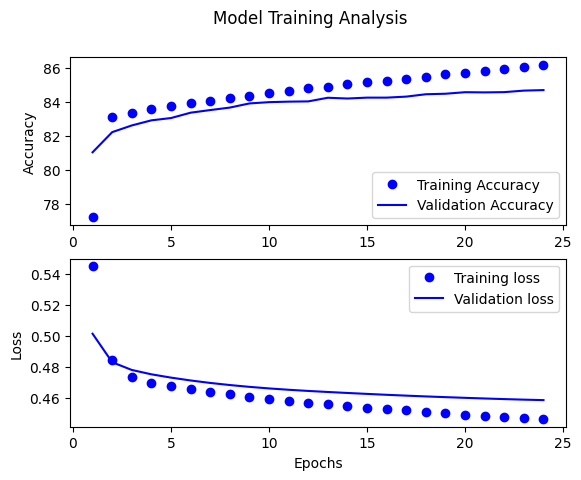

In [94]:
# prepare results for visualization
epochs = range(1, len(train_acc) + 1)
train_acc = [x * 100 for x in train_acc]
valid_acc = [x * 100 for x in valid_acc]

# initialize plot field
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Model Training Analysis')

# plot accuracy results
ax1.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
ax1.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend()
# ax1.figure()

# plot loss results
ax2.plot(epochs, train_loss, 'bo', label='Training loss')
ax2.plot(epochs, valid_loss, 'b', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
# ax2.figure()

In [95]:
# set the model to evaluation mode
model.eval()

# predict on validation set
with torch.no_grad():
    pred = model(torch.tensor(X_valid.values))
    pred = torch.argmax(pred, dim = 1).numpy()

# calculate validation accuracy
accuracy = (pred == y_valid).mean() * 100
print(f"Validation accuracy: {accuracy.round(2)}%")

Validation accuracy: 84.68%
